In [22]:
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # comment out if we want raw matplotlib only
import os
from collections import Counter

In [2]:
def load_metadata(file_path):
    """
    Reads a JSON file and flattens it into a DataFrame.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        pd.DataFrame: Processed metadata DataFrame.
    """
    with open(file_path, "r") as f:
        data = json.load(f)

    records = []
    for record_id, record in data.items():
        attributes = record.get('attributes', {})
        attributes['id'] = record_id  # Include ID as a column
        records.append(attributes)

    return pd.DataFrame(records)
file_path = "/projectnb/sparkgrp/ml-bpl-rag-data/full_data/bpl_meta.json"
df = load_metadata(file_path)


In [3]:
print("\nDataset Overview:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304242 entries, 0 to 1304241
Columns: 138 entries, id to frequency_tsi
dtypes: float64(1), int64(1), object(136)
memory usage: 1.3+ GB
None

First 5 rows:
                           id    system_create_dtsi  system_modified_dtsi  \
0  commonwealth-oai:n5842629x  2023-09-07T04:34:04Z  2024-05-31T03:21:27Z   
1  commonwealth-oai:ft84d3073  2023-09-07T05:03:38Z  2024-05-31T03:29:29Z   
2      commonwealth:ms35v4434  2015-06-29T15:35:22Z  2023-11-03T18:53:53Z   
3      commonwealth:6d570801f  2014-11-18T16:26:12Z  2021-10-09T10:14:50Z   
4  commonwealth-oai:ks65nx01m  2024-03-27T03:56:01Z  2024-03-27T03:56:20Z   

        curator_model_ssi curator_model_suffix_ssi  \
0  Curator::DigitalObject            DigitalObject   
1  Curator::DigitalObject            DigitalObject   
2  Curator::DigitalObject            DigitalObject   
3  Curator::DigitalObject            DigitalObject   
4  Curator::DigitalObject            Digit

In [ ]:
# Visualize missing values in the dataset
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


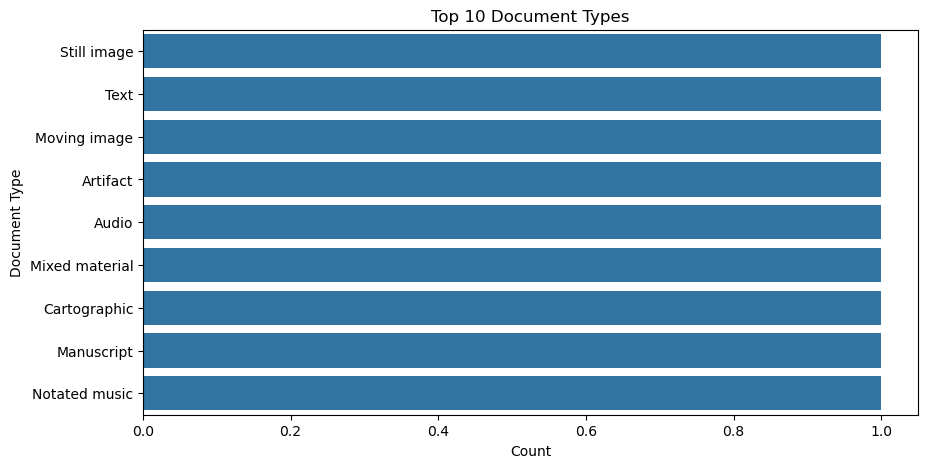

In [5]:
# Plot the distribution of the top 10 document types
if 'type_of_resource_ssim' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df['type_of_resource_ssim'].explode().value_counts().index[:10], 
                  order=df['type_of_resource_ssim'].explode().value_counts().index[:10])
    plt.title("Top 10 Document Types")
    plt.xlabel("Count")
    plt.ylabel("Document Type")
    plt.show()


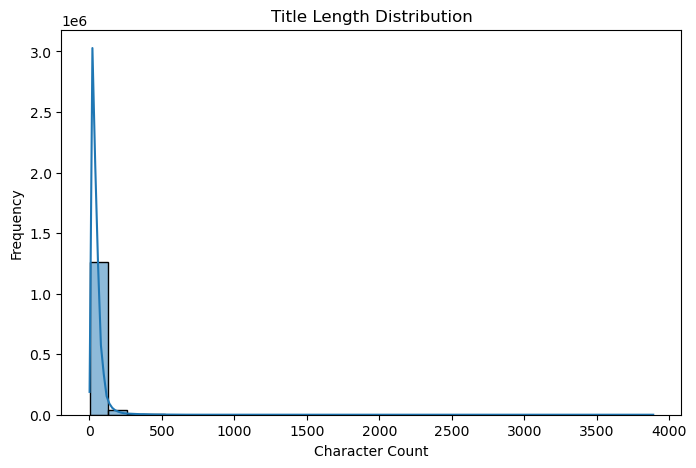

In [6]:
# Plot the distribution of title lengths
if 'title_info_primary_tsi' in df.columns:
    df['title_length'] = df['title_info_primary_tsi'].astype(str).apply(len)
    plt.figure(figsize=(8, 5))
    sns.histplot(df['title_length'], bins=30, kde=True)
    plt.title("Title Length Distribution")
    plt.xlabel("Character Count")
    plt.ylabel("Frequency")
    plt.show()


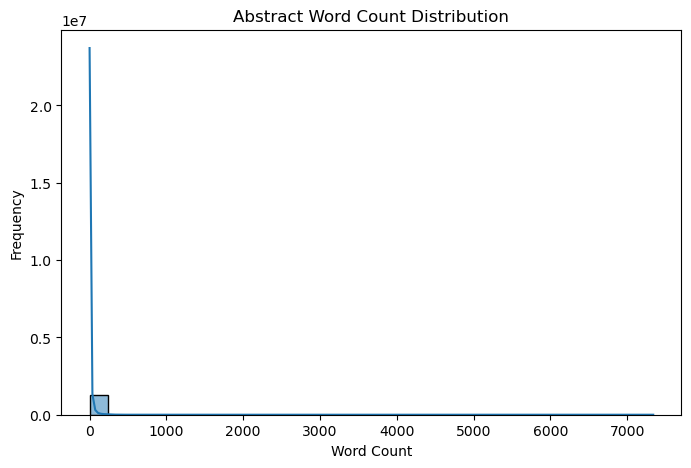

In [7]:
# Plot the distribution of abstract word counts
if 'abstract_tsi' in df.columns:
    df['abstract_length'] = df['abstract_tsi'].astype(str).apply(lambda x: len(x.split()))
    plt.figure(figsize=(8, 5))
    sns.histplot(df['abstract_length'], bins=30, kde=True)
    plt.title("Abstract Word Count Distribution")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.show()


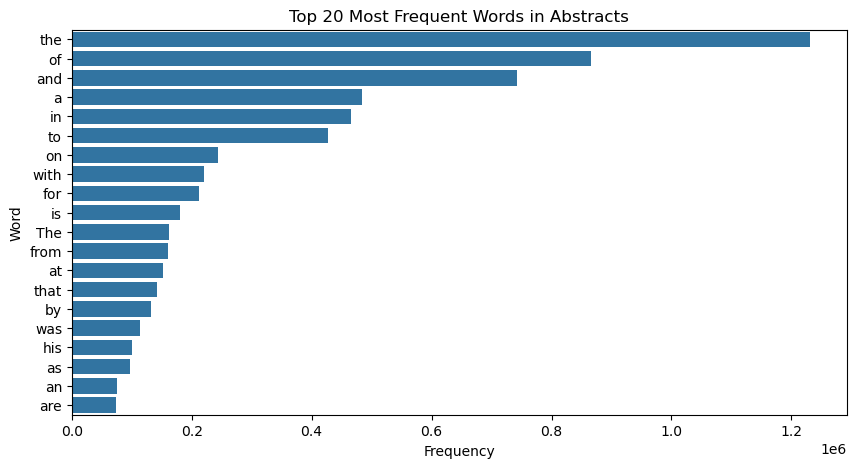

In [8]:
# Displaying the most common words in abstracts
if 'abstract_tsi' in df.columns:
    word_list = " ".join(df['abstract_tsi'].dropna()).split()
    common_words = Counter(word_list).most_common(20)
    
    words, counts = zip(*common_words)
    
    # Convert tuples to lists
    words = list(words)
    counts = list(counts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=counts, y=words)
    plt.title("Top 20 Most Frequent Words in Abstracts")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()

/scratch/3063068.1.cds/ipykernel_2502545/1419034166.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_fields.index, rotation=45, ha='right')


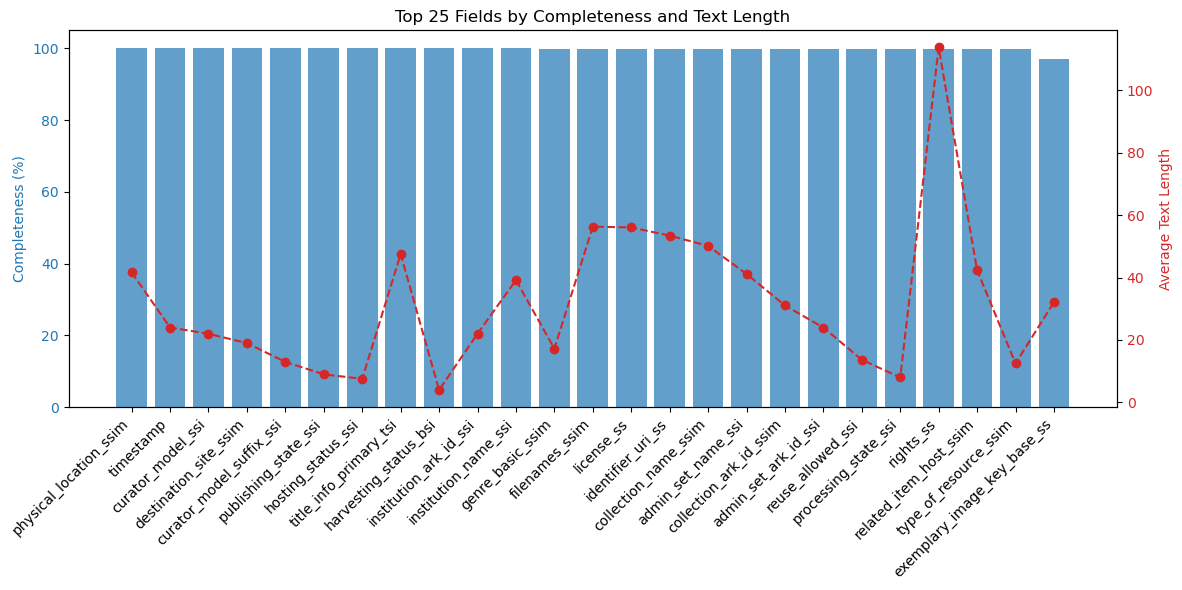

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Exclude system-level and technical fields if they don't matter for search
ignore_fields = ['id', 'system_create_dtsi', 'system_modified_dtsi']

# Completeness — % of non-null entries per column
completeness = df.drop(columns=ignore_fields, errors='ignore').notnull().mean()

# Text Length — Average length of text in each column
text_lengths = {}
for col in df.columns:
    if df[col].dtype == 'object' and col not in ignore_fields:
        text_lengths[col] = df[col].dropna().astype(str).apply(len).mean()

text_lengths = pd.Series(text_lengths)

# Combine into DataFrame
field_quality = pd.DataFrame({
    'Completeness': completeness,
    'Average Text Length': text_lengths
}).dropna().sort_values(['Completeness', 'Average Text Length'], ascending=[False, False])

# Filter top 25 fields
top_fields = field_quality.head(25)

# Plot Completeness and Text Length
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.bar(top_fields.index, top_fields['Completeness'] * 100, color=color, alpha=0.7)
ax1.set_ylabel('Completeness (%)', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_fields.index, rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(top_fields.index, top_fields['Average Text Length'], color=color, marker='o', linestyle='--')
ax2.set_ylabel('Average Text Length', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Top 25 Fields by Completeness and Text Length')
plt.tight_layout()
plt.show()


The most complete fields are system-level metadata like physical_location_ssim and timestamp, which are reliable but not very useful for search. Key descriptive fields like title_info_primary_tsi have good completeness and reasonable length, making them strong candidates for retrieval. In contrast, fields like rights_ssi and related_item_host_ssim show inconsistent lengths, reflecting uneven metadata quality. Overall, descriptive metadata is often shorter than ideal, which may limit search relevance if not addressed in preprocessing.

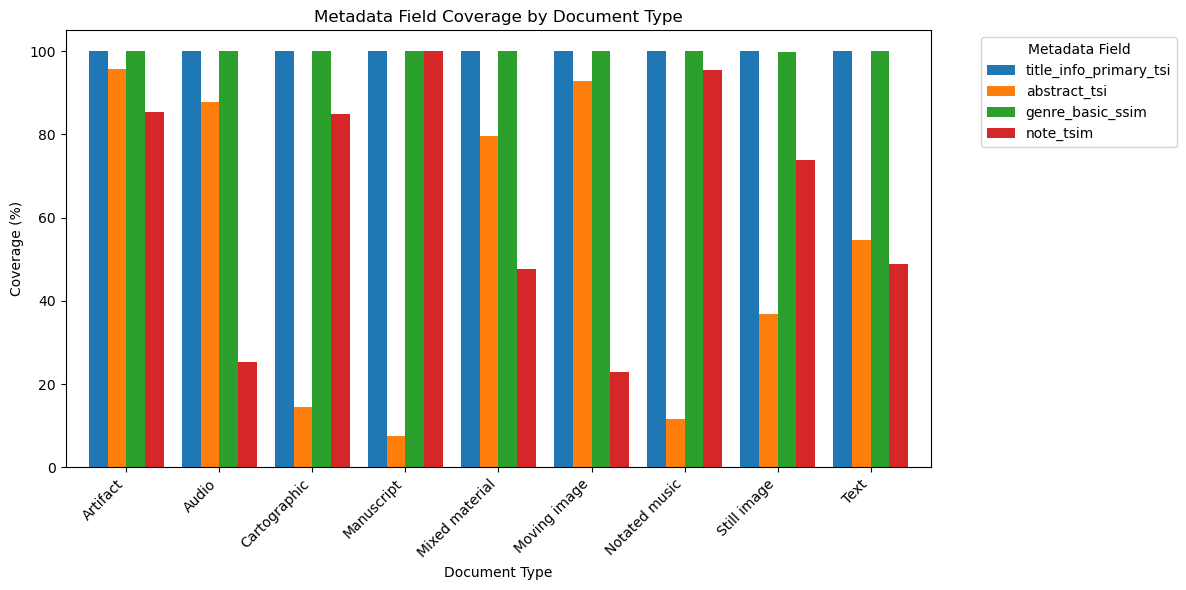

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure type_of_resource_ssim exists
if 'type_of_resource_ssim' not in df.columns:
    raise ValueError("Column 'type_of_resource_ssim' is missing from the DataFrame. This analysis depends on it.")

# Expand list column if needed
df_exploded = df.explode('type_of_resource_ssim')

# Define key fields (but filter out any that are missing)
key_fields = [
    'title_info_primary_tsi',
    'abstract_tsi',
    'subject_tsim',
    'genre_basic_ssim',
    'note_tsim'
]

available_fields = [col for col in key_fields if col in df.columns]

if not available_fields:
    raise ValueError("None of the expected key fields are present in the DataFrame.")

# Completeness calculation by document type
coverage = df_exploded.groupby('type_of_resource_ssim')[available_fields].apply(lambda g: g.notnull().mean() * 100)

# Plot
coverage.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title('Metadata Field Coverage by Document Type')
plt.ylabel('Coverage (%)')
plt.xlabel('Document Type')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metadata Field', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


Metadata coverage varies significantly across document types. Titles and genres are consistently present across all types, making them reliable fields for filtering and retrieval. However, abstracts and notes show much more variability. Text-based items like manuscripts and text documents have strong abstract coverage, while cartographic and notated music items often lack abstracts entirely. Notes are particularly sparse for cartographic and notated music items, indicating uneven descriptive metadata practices for certain formats. This imbalance means that search relevance could be biased toward text-heavy materials unless additional content is generated for under-described formats like images and maps.

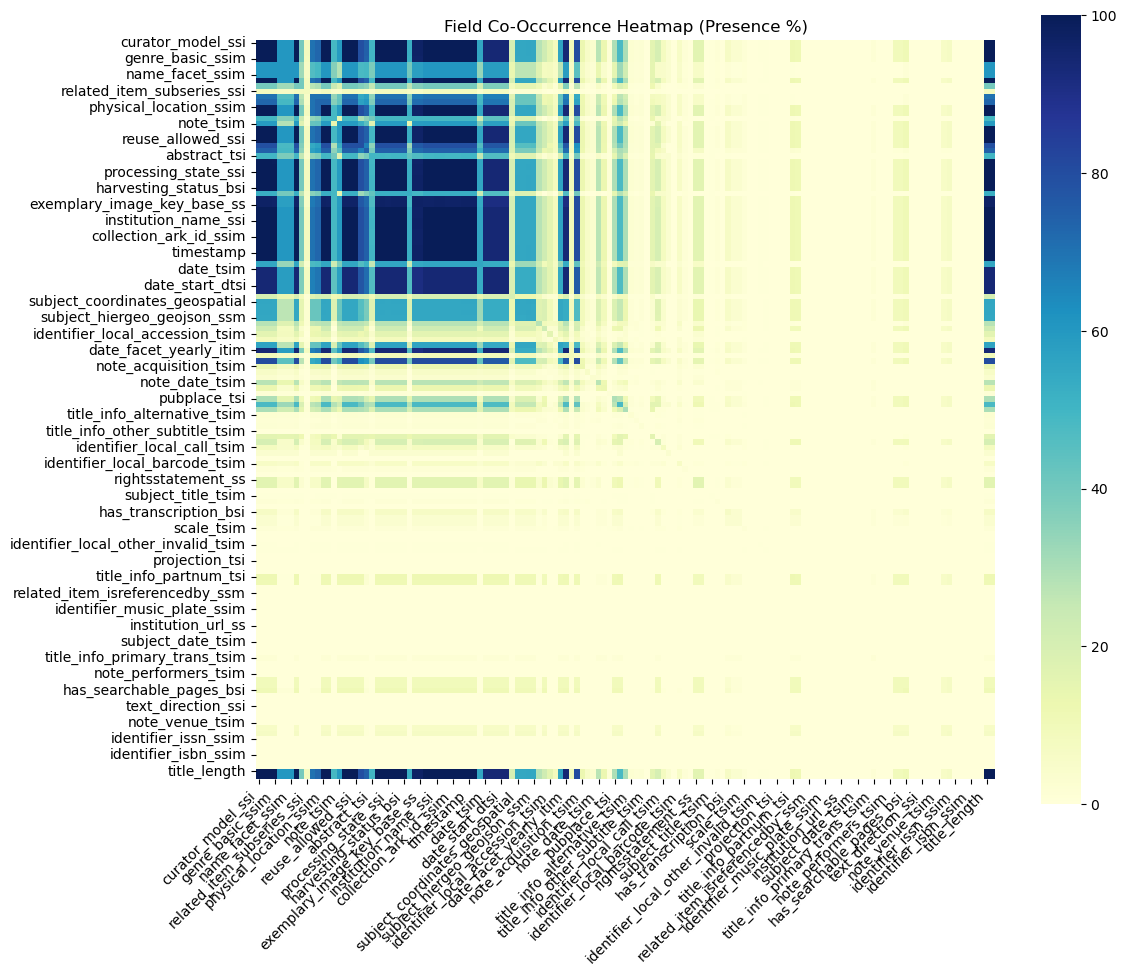

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Drop system and technical fields to focus on descriptive content
ignore_fields = ['id', 'system_create_dtsi', 'system_modified_dtsi']

descriptive_fields = [col for col in df.columns if col not in ignore_fields]

# Create a DataFrame that is True/False for presence/absence of each field
field_presence = df[descriptive_fields].notnull().astype(int)

# Calculate co-occurrence matrix (percentage of records where both fields are present)
co_occurrence = field_presence.T.dot(field_presence) / len(df) * 100

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, cmap="YlGnBu", annot=False, square=True)
plt.title("Field Co-Occurrence Heatmap (Presence %)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The heatmap shows that some fields tend to show up together a lot, especially basic system information like curator model and physical location. Important fields like titles and abstracts also often appear together, which is helpful for search. On the other hand, some fields, like notes or geospatial data, rarely appear at the same time as others. This means certain types of information are only filled in for some records, not all. To make search work well, we may need to rely on fields like titles and genres more often, especially when things like abstracts or notes are missing.

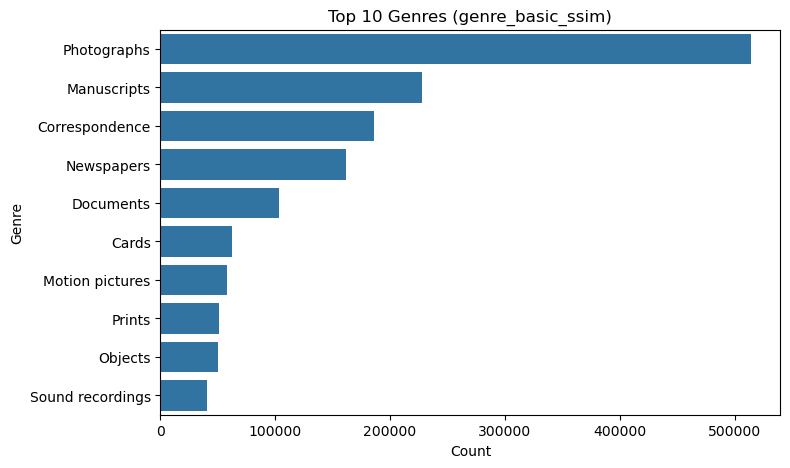

In [12]:
# 1. Distribution of genre_basic_ssim (top 10)
if "genre_basic_ssim" in df.columns:
    df_exploded_genre = df.explode("genre_basic_ssim")
    genre_counts = df_exploded_genre["genre_basic_ssim"].value_counts().head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title("Top 10 Genres (genre_basic_ssim)")
    plt.xlabel("Count")
    plt.ylabel("Genre")
    plt.show()
else:
    print("Column 'genre_basic_ssim' not found, skipping genre plot.")

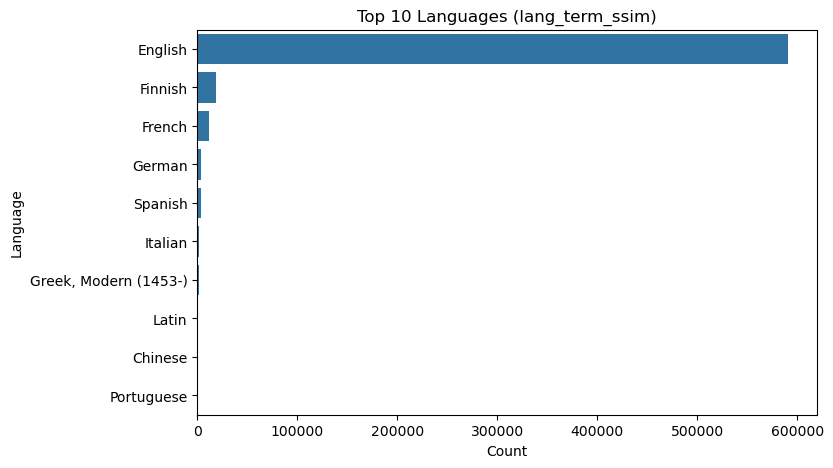

In [13]:
# 2. Language distribution (lang_term_ssim), top 10
if "lang_term_ssim" in df.columns:
    df_exploded_lang = df.explode("lang_term_ssim")
    lang_counts = df_exploded_lang["lang_term_ssim"].value_counts().head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=lang_counts.values, y=lang_counts.index)
    plt.title("Top 10 Languages (lang_term_ssim)")
    plt.xlabel("Count")
    plt.ylabel("Language")
    plt.show()
else:
    print("Column 'lang_term_ssim' not found, skipping language plot.")

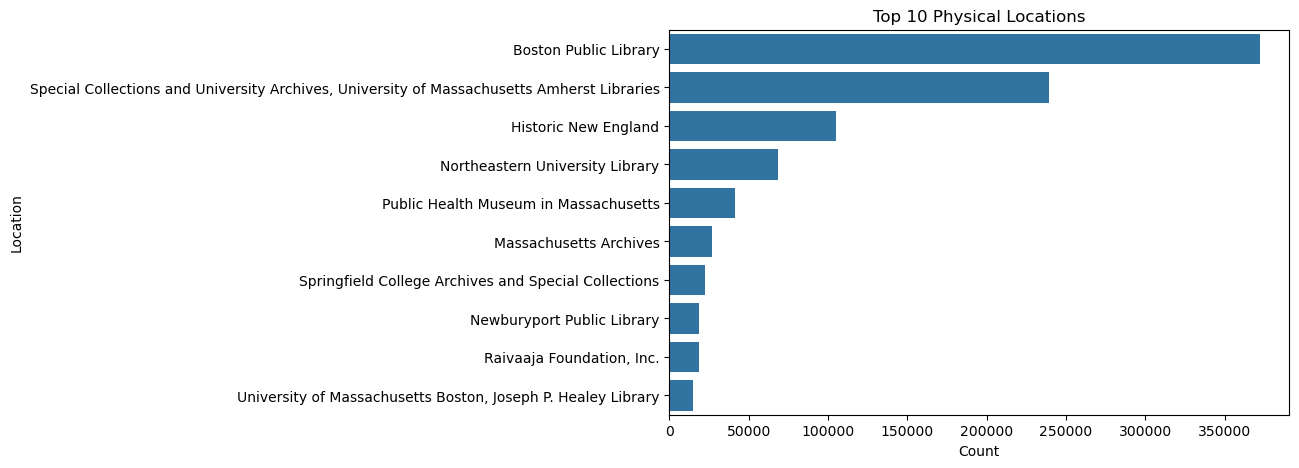

In [14]:
# 3. Physical location distribution (physical_location_ssim), top 10
if "physical_location_ssim" in df.columns:
    df_exploded_loc = df.explode("physical_location_ssim")
    loc_counts = df_exploded_loc["physical_location_ssim"].value_counts().head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=loc_counts.values, y=loc_counts.index)
    plt.title("Top 10 Physical Locations")
    plt.xlabel("Count")
    plt.ylabel("Location")
    plt.show()
else:
    print("Column 'physical_location_ssim' not found, skipping location plot.")

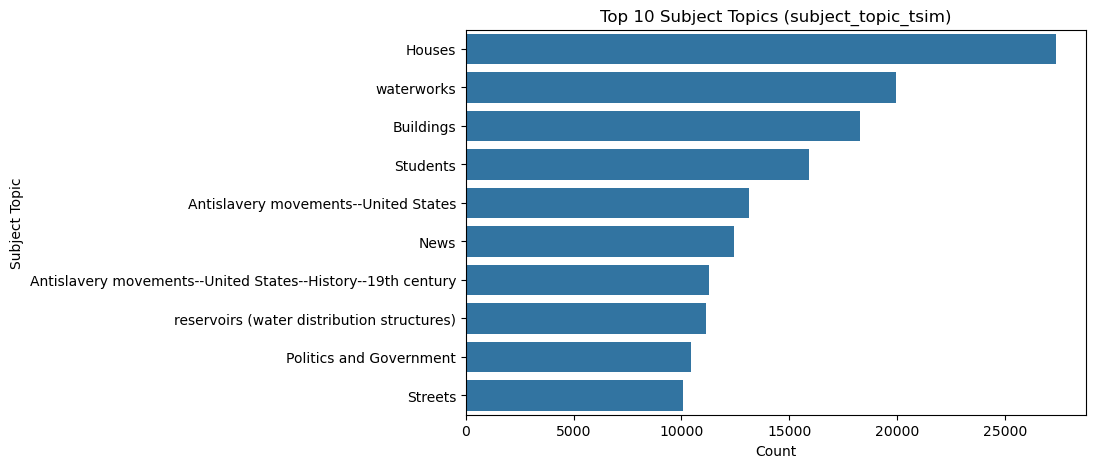

In [15]:
# 4. Subject topic distribution (subject_topic_tsim), top 10
if "subject_topic_tsim" in df.columns:
    df_exploded_subj = df.explode("subject_topic_tsim")
    subj_counts = df_exploded_subj["subject_topic_tsim"].value_counts().head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=subj_counts.values, y=subj_counts.index)
    plt.title("Top 10 Subject Topics (subject_topic_tsim)")
    plt.xlabel("Count")
    plt.ylabel("Subject Topic")
    plt.show()
else:
    print("Column 'subject_topic_tsim' not found, skipping subject topic plot.")

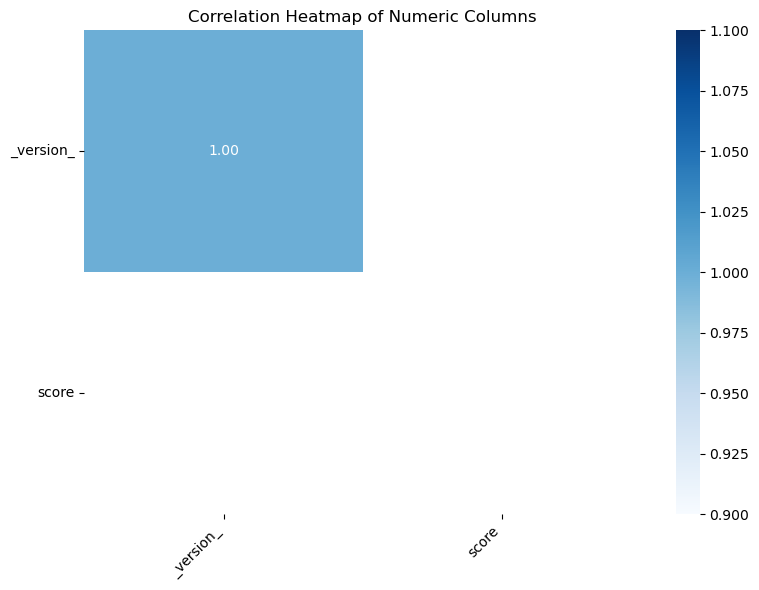

In [16]:
# 5. If we have numeric columns (besides the artificially created ones),
#    we can do a quick correlation heatmap. For example:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Filter out the ones you created, if you wish
maybe_ignore = ["title_length", "abstract_length"]
numeric_cols = [c for c in numeric_cols if c not in maybe_ignore]

if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Columns")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No multiple numeric columns to correlate, skipping correlation heatmap.")

In [ ]:
df.to_csv("cleaned_bpl_metadata.csv", index=False)
print("Cleaned dataset saved successfully.")

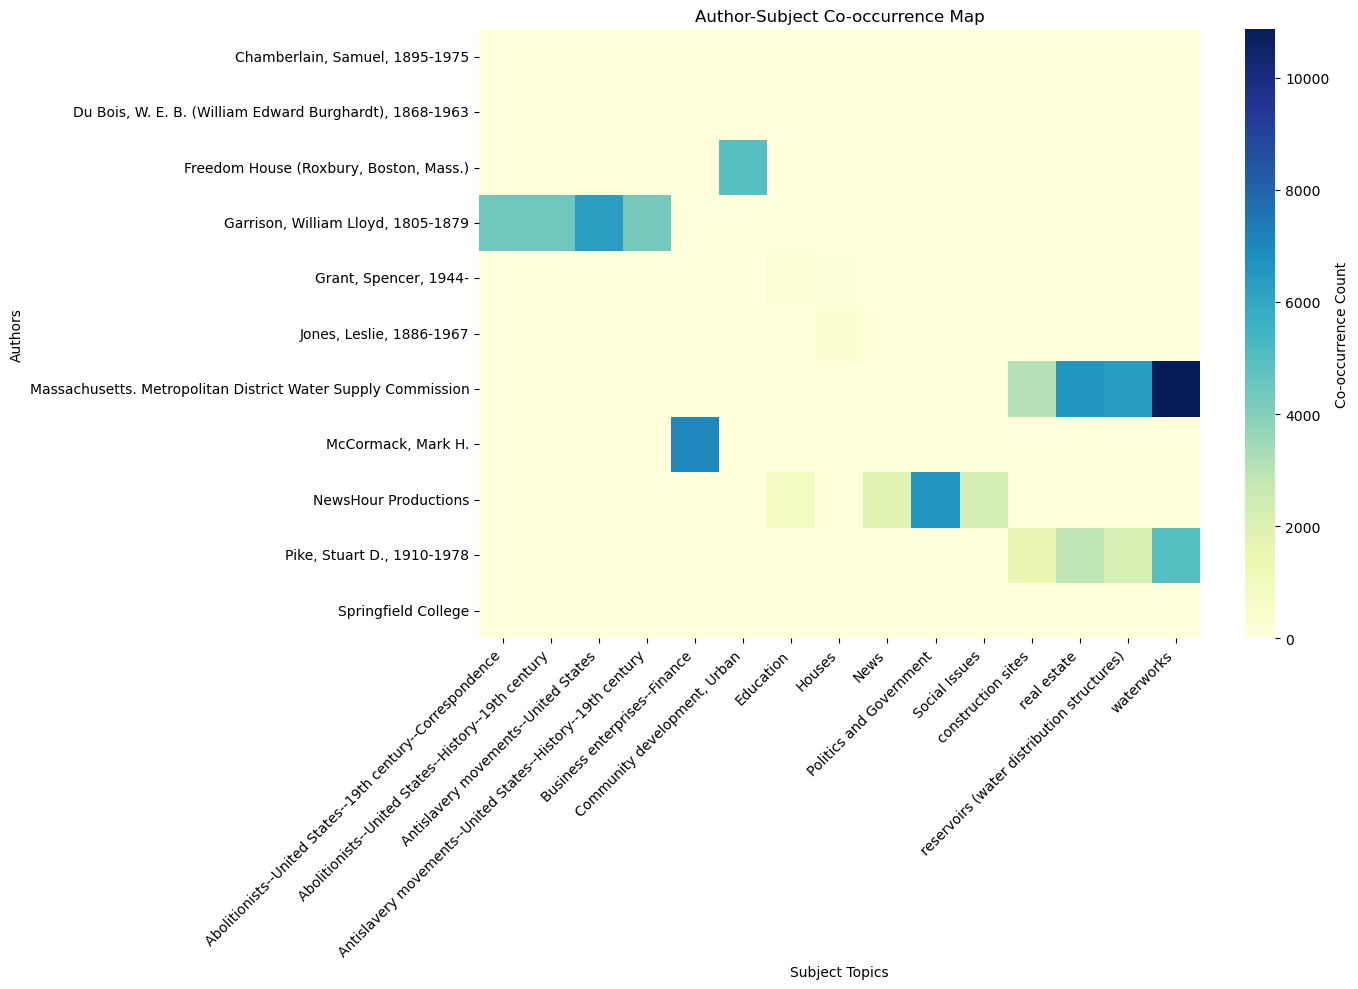

In [23]:
# Network analysis of subjects and authors
if 'subject_topic_tsim' in df.columns and 'name_tsim' in df.columns:
    # Get records with both subject and author
    valid_records = df.dropna(subset=['subject_topic_tsim', 'name_tsim'])
    
    # Create exploded DataFrame for subject-author pairs
    df_author = valid_records.explode('name_tsim')
    df_subject = df_author.explode('subject_topic_tsim')
    
    # Filter to top subjects and authors
    top_subjects = df_subject['subject_topic_tsim'].value_counts().head(15).index.tolist()
    top_authors = df_subject['name_tsim'].value_counts().head(15).index.tolist()
    
    # Filter the dataframe
    df_network = df_subject[
        (df_subject['subject_topic_tsim'].isin(top_subjects)) & 
        (df_subject['name_tsim'].isin(top_authors))
    ]
    
    # Create a co-occurrence count
    author_subject_counts = df_network.groupby(['name_tsim', 'subject_topic_tsim']).size().reset_index(name='count')
    
    # Plot as a heatmap
    pivot_table = author_subject_counts.pivot(index='name_tsim', columns='subject_topic_tsim', values='count')
    pivot_table = pivot_table.fillna(0)
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_table, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Co-occurrence Count'})
    plt.title("Author-Subject Co-occurrence Map")
    plt.xlabel("Subject Topics")
    plt.ylabel("Authors")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'subject_topic_tsim' or 'name_tsim' not found, skipping network analysis.")

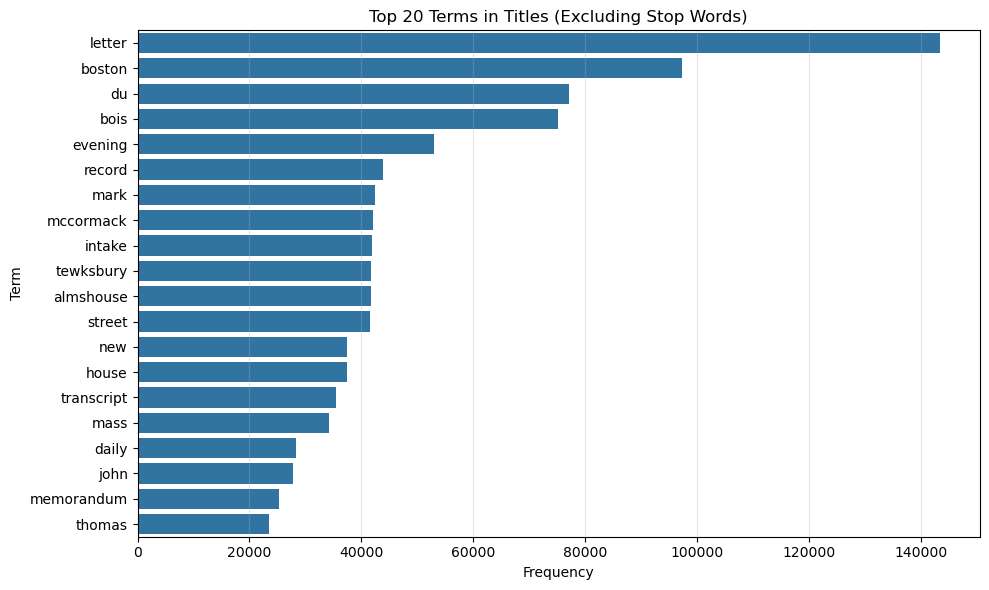

In [24]:
# Term frequency analysis for titles
if 'title_info_primary_tsi' in df.columns:
    try:
        import nltk
        from nltk.corpus import stopwords
        from nltk.tokenize import word_tokenize
        from collections import Counter
        import string
        
        # Download necessary NLTK data
        try:
            nltk.data.find('corpora/stopwords')
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('stopwords')
            nltk.download('punkt')
        
        # Define stop words
        stop_words = set(stopwords.words('english'))
        additional_stops = {'the', 'and', 'of', 'to', 'a', 'in', 'for', 'on', 'with', 'by', 'at', 'from'}
        stop_words.update(additional_stops)
        
        def clean_text(text):
            # Convert to lowercase and tokenize
            tokens = word_tokenize(text.lower())
            # Remove punctuation and stop words
            tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words]
            # Filter out non-alphabetic tokens and single characters
            tokens = [token for token in tokens if token.isalpha() and len(token) > 1]
            return tokens
        
        # Process titles
        title_texts = df['title_info_primary_tsi'].dropna().astype(str).tolist()
        title_tokens = []
        for text in title_texts:
            title_tokens.extend(clean_text(text))
        
        title_freq = Counter(title_tokens).most_common(20)
        
        # Plot title term frequency
        plt.figure(figsize=(10, 6))
        words, counts = zip(*title_freq)
        sns.barplot(x=list(counts), y=list(words))
        plt.title("Top 20 Terms in Titles (Excluding Stop Words)")
        plt.xlabel("Frequency")
        plt.ylabel("Term")
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("NLTK not installed. Run 'pip install nltk' to use this feature.")

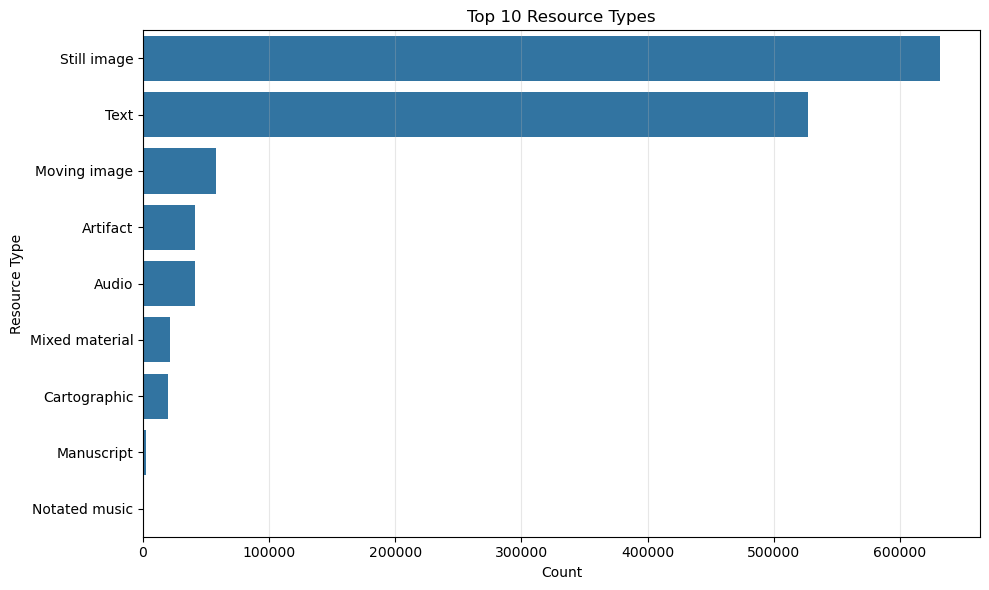

In [25]:
# Resource type-specific analysis
if 'type_of_resource_ssim' in df.columns:
    # Get top 5 resource types
    resource_counts = df.explode('type_of_resource_ssim')['type_of_resource_ssim'].value_counts()
    top_resources = resource_counts.head(5).index.tolist()
    
    # Plot top resource types
    plt.figure(figsize=(10, 6))
    sns.barplot(x=resource_counts.head(10).values, y=resource_counts.head(10).index)
    plt.title("Top 10 Resource Types")
    plt.xlabel("Count")
    plt.ylabel("Resource Type")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

Found list columns: ['genre_basic_ssim', 'name_tsim', 'name_role_tsim', 'name_facet_ssim', 'related_item_host_ssim', 'subject_topic_tsim', 'subject_facet_ssim', 'physical_location_ssim', 'note_tsim', 'type_of_resource_ssim', 'destination_site_ssim', 'collection_name_ssim', 'collection_ark_id_ssim', 'filenames_ssim']


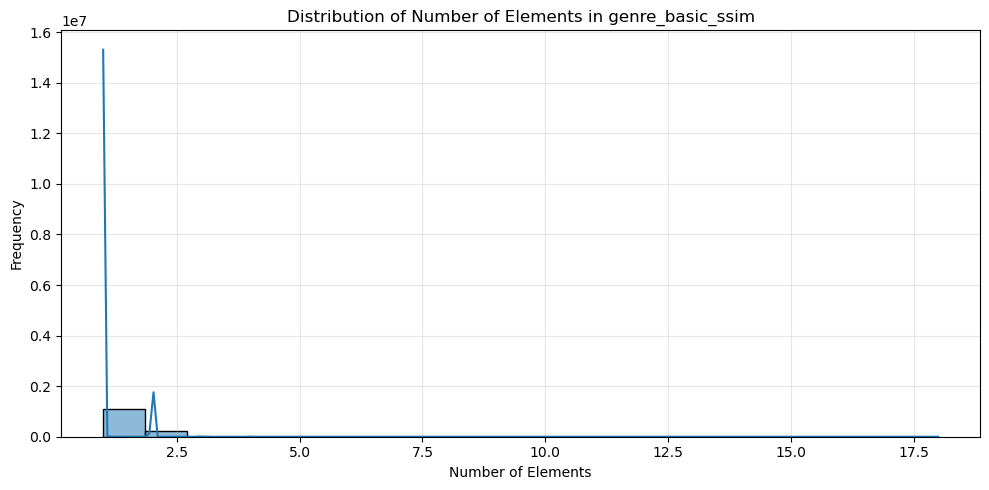

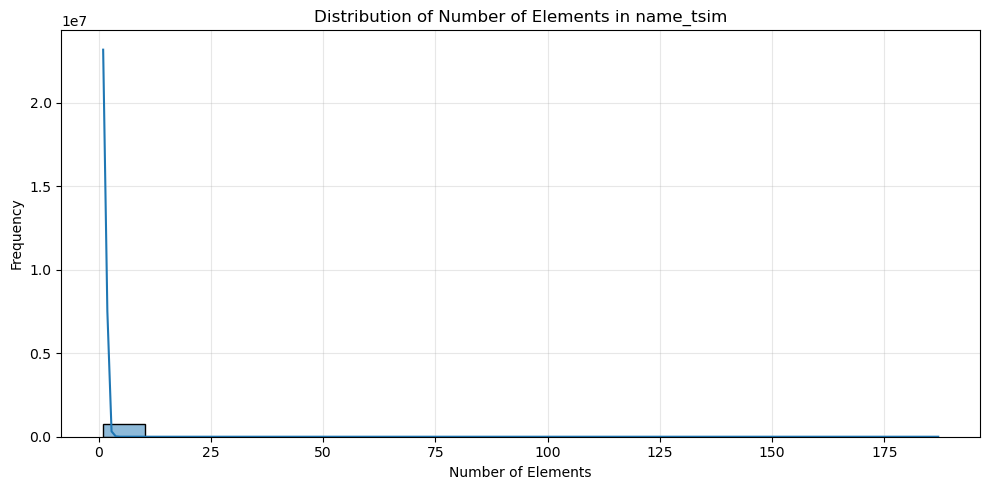

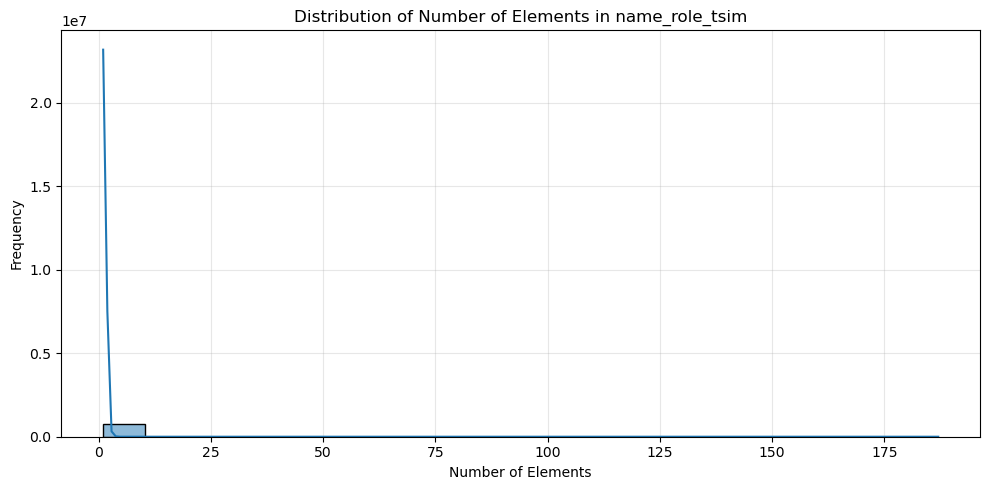

In [27]:
# Analyze element counts in list fields
list_columns = [col for col in df.columns if df[col].dtype == 'object' and 
               isinstance(df[col].iloc[0], list) if len(df) > 0 and not pd.isna(df[col].iloc[0])]

if list_columns:
    print(f"Found list columns: {list_columns}")
    
    # Analyze element count distribution for each list column (limit to first 3)
    for i, col in enumerate(list_columns[:3]):
        element_counts = df[col].apply(lambda x: len(x) if isinstance(x, list) else 0)
        
        plt.figure(figsize=(10, 5))
        sns.histplot(element_counts[element_counts > 0], kde=True, bins=20)
        plt.title(f"Distribution of Number of Elements in {col}")
        plt.xlabel("Number of Elements")
        plt.ylabel("Frequency")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No list columns found in the dataset.")

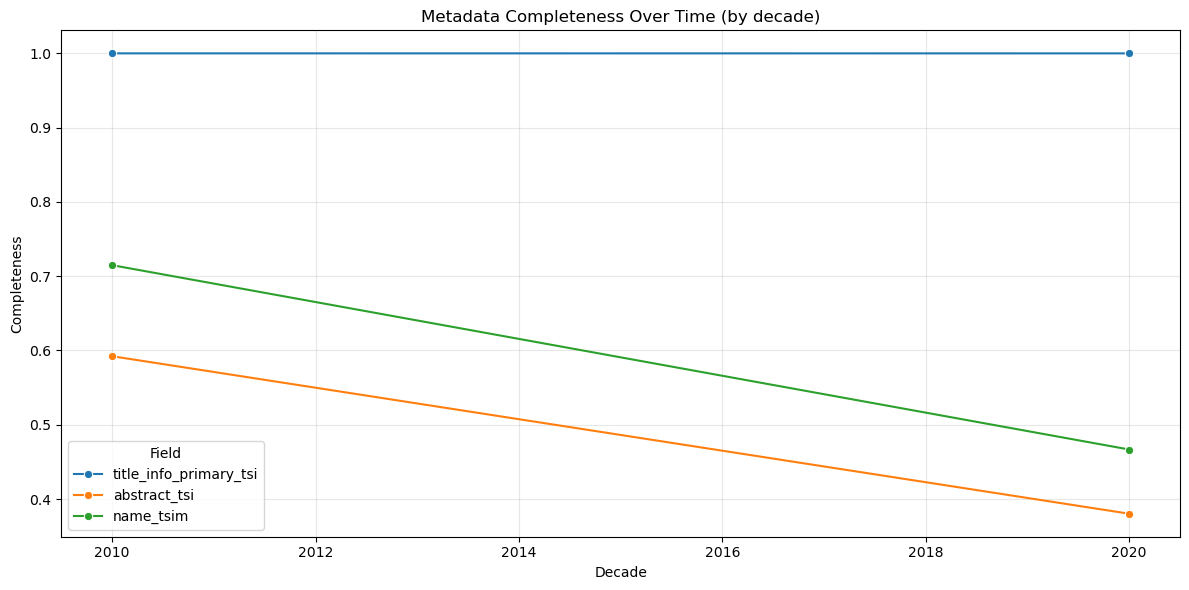

In [28]:
# Metadata completeness over time
date_columns = ['date_issued_ssim', 'date_created_ssim', 'system_create_dtsi', 'system_modified_dtsi']
available_date_columns = [col for col in date_columns if col in df.columns]

if available_date_columns:
    date_col = available_date_columns[0]  # Use the first available date column
    
    # Process dates - extract year
    if date_col == 'system_create_dtsi' or date_col == 'system_modified_dtsi':
        # Parse ISO format dates
        df['year'] = pd.to_datetime(df[date_col], errors='coerce').dt.year
    else:
        # Extract year from string
        df['year'] = df[date_col].astype(str).apply(
            lambda x: re.search(r'\b(\d{4})\b', x).group(1) if re.search(r'\b(\d{4})\b', x) else None
        )
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
    
    # Filter to valid years and create decade bins
    valid_years_df = df[df['year'].between(1500, 2024)]
    valid_years_df['decade'] = (valid_years_df['year'] // 10) * 10
    
    # Key metadata fields to track over time
    key_fields = [
        'title_info_primary_tsi', 
        'abstract_tsi', 
        'subject_tsim', 
        'name_tsim'
    ]
    
    # Filter only fields that exist in the dataset
    available_key_fields = [field for field in key_fields if field in df.columns]
    
    if len(available_key_fields) > 0:
        # Calculate completeness by decade
        decade_completeness = valid_years_df.groupby('decade')[available_key_fields].apply(
            lambda x: x.notnull().mean()
        ).reset_index()
        
        # Reshape for plotting
        decade_completeness_melted = pd.melt(
            decade_completeness, 
            id_vars=['decade'], 
            value_vars=available_key_fields,
            var_name='Field', 
            value_name='Completeness'
        )
        
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=decade_completeness_melted,
            x='decade', 
            y='Completeness',
            hue='Field',
            marker='o'
        )
        plt.title(f"Metadata Completeness Over Time (by decade)")
        plt.xlabel("Decade")
        plt.ylabel("Completeness")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("No suitable date columns found for temporal completeness analysis.")

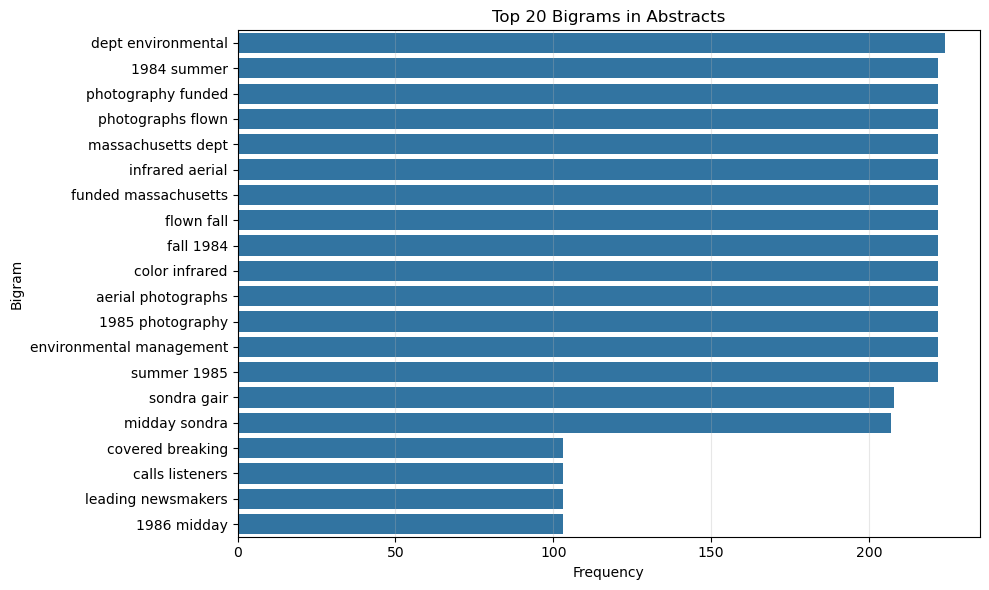

In [30]:
# Bigram analysis for abstracts
if 'abstract_tsi' in df.columns:
    try:
        from sklearn.feature_extraction.text import CountVectorizer
        
        # Prepare text data
        abstracts = df['abstract_tsi'].dropna().astype(str).tolist()[:1000]  # Limit to 1000 for performance
        
        # Create bigram vectorizer
        bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
        bigram_matrix = bigram_vectorizer.fit_transform(abstracts)
        
        # Get bigram counts
        bigram_counts = np.asarray(bigram_matrix.sum(axis=0)).flatten()
        bigram_names = bigram_vectorizer.get_feature_names_out()
        
        # Sort and get top bigrams
        bigram_ranking = np.argsort(-bigram_counts)
        top_bigrams = [(bigram_names[i], bigram_counts[i]) for i in bigram_ranking[:20]]
        
        # Plot bigram frequency
        plt.figure(figsize=(10, 6))
        bigram_words, bigram_freq = zip(*top_bigrams)
        sns.barplot(x=list(bigram_freq), y=list(bigram_words))
        plt.title("Top 20 Bigrams in Abstracts")
        plt.xlabel("Frequency")
        plt.ylabel("Bigram")
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
            
    except ImportError:
        print("scikit-learn not installed. Run 'pip install scikit-learn' to use this feature.")

/scratch/3063068.1.cds/ipykernel_2502545/2326898127.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


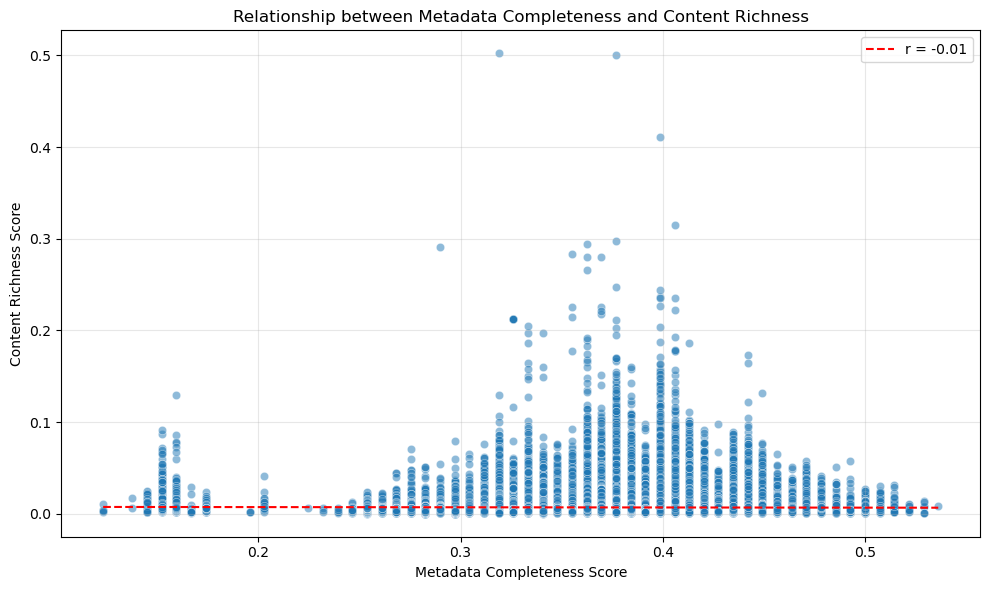

In [31]:
# Completeness vs content richness analysis
if 'title_info_primary_tsi' in df.columns:
    # Calculate overall completeness score
    metadata_fields = [col for col in df.columns if col not in ['id', 'title_length', 'abstract_length']]
    df['completeness_score'] = df[metadata_fields].notnull().mean(axis=1)
    
    # Calculate content richness based on text length
    text_fields = ['title_info_primary_tsi', 'abstract_tsi']
    available_text_fields = [field for field in text_fields if field in df.columns]
    
    if available_text_fields:
        for field in available_text_fields:
            field_name = field.split('_')[0] + '_length'
            df[field_name] = df[field].astype(str).apply(lambda x: len(x.split()) if x != 'nan' else 0)
        
        # Normalize text lengths
        for field in available_text_fields:
            field_name = field.split('_')[0] + '_length'
            if field_name in df.columns and df[field_name].max() > 0:
                df[field_name + '_norm'] = df[field_name] / df[field_name].max()
        
        # Calculate combined content richness score
        norm_fields = [field.split('_')[0] + '_length_norm' for field in available_text_fields]
        available_norm_fields = [field for field in norm_fields if field in df.columns]
        
        if available_norm_fields:
            df['content_richness'] = df[available_norm_fields].mean(axis=1)
            
            # Plot relationship
            plt.figure(figsize=(10, 6))
            sns.scatterplot(
                x='completeness_score', 
                y='content_richness', 
                data=df,
                alpha=0.5
            )
            
            # Add trend line
            from scipy import stats
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                df['completeness_score'].dropna(), 
                df['content_richness'].dropna()
            )
            
            x = np.array([df['completeness_score'].min(), df['completeness_score'].max()])
            y = intercept + slope * x
            plt.plot(x, y, 'r--', label=f'r = {r_value:.2f}')
            
            plt.title("Relationship between Metadata Completeness and Content Richness")
            plt.xlabel("Metadata Completeness Score")
            plt.ylabel("Content Richness Score")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

/scratch/3063068.1.cds/ipykernel_2502545/1847361395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_title['title_length'] = df_with_title['title_info_primary_tsi'].astype(str).apply(len)


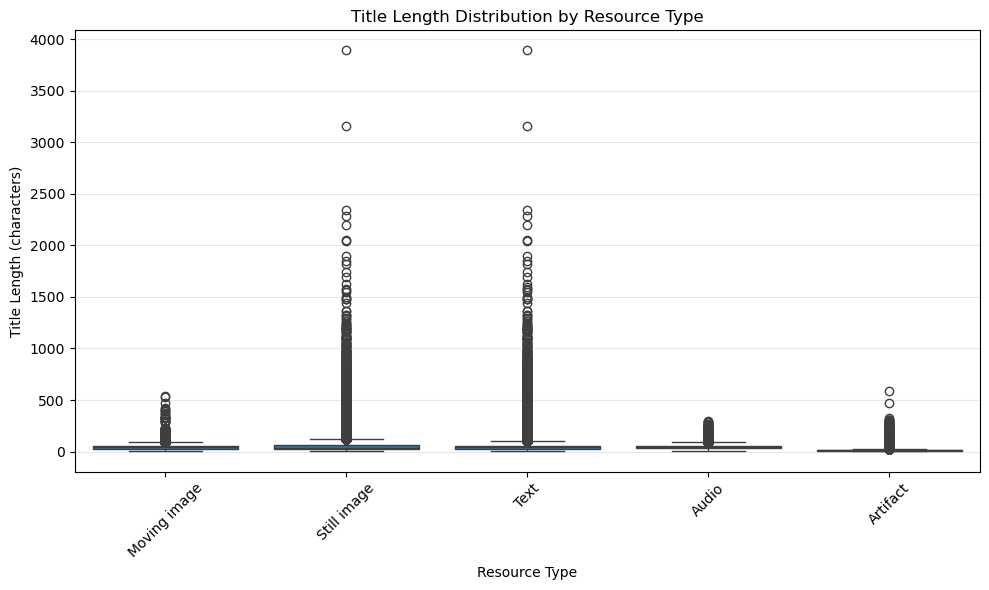

In [32]:
# Title length distribution by resource type
if 'type_of_resource_ssim' in df.columns and 'title_info_primary_tsi' in df.columns:
    df_with_title = df.dropna(subset=['title_info_primary_tsi', 'type_of_resource_ssim'])
    df_with_title['title_length'] = df_with_title['title_info_primary_tsi'].astype(str).apply(len)
    
    df_exploded = df_with_title.explode('type_of_resource_ssim')
    
    # Get top resource types
    top_resources = df_exploded['type_of_resource_ssim'].value_counts().head(5).index.tolist()
    df_filtered = df_exploded[df_exploded['type_of_resource_ssim'].isin(top_resources)]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='type_of_resource_ssim', y='title_length', data=df_filtered)
    plt.title("Title Length Distribution by Resource Type")
    plt.xlabel("Resource Type")
    plt.ylabel("Title Length (characters)")
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()